In [1]:
%matplotlib inline
from skimage import io, data
import cv2 #OpenCV
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
import time
#print("Versão do OpenCV utilizada\n {}".format(cv2.__version__))

/home/lopac/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def distribuited_fuzzy_C_means(data_batch, K, GPU_names, initial_centers, n_max_iters):
    setup_ts = time.time()
    number_of_gpus = len(GPU_names)
    
    sizes = [len(arg) for arg in np.array_split( data_batch, len(GPU_names))]
    result_matrix = [[] for _ in GPU_names]
    
    partial_Mu_sum_list = []
    partial_Mu_X_sum_list = []
    
    tf.reset_default_graph()
    with tf.name_scope('global'):
        with tf.device('/cpu:0'):
            all_data = tf.placeholder(data_batch.dtype, shape=(data_batch.shape), name='all_data')
            
            parts = tf.split(all_data, sizes, 0)

            global_centroids = tf.Variable(initial_centers)
            
    for GPU_num in range(number_of_gpus):
        GPU_name = GPU_names[GPU_num]
        
        (X_mat) = parts[GPU_num]
        (N, M) = X_mat.get_shape().as_list()
  
        with tf.name_scope('scope_' + str(GPU_num)):
            with tf.device(GPU_name) :
                ####
                # In the coments we denote :
                # => N = Number of Observations
                # => M = Number of Dimensions
                # => K = Number of Centers
                ####
                # Data for GPU GPU_num to Clusterize
                X = tf.Variable(X_mat)

                # Reshapes rep_centroids and  rep_points to format N x K x M so that 
                # the 2 matrixes have the same size
                rep_centroids = tf.reshape(tf.tile(global_centroids, [N, 1]), [N, K, M])
                rep_points = tf.reshape(tf.tile(X, [1, K]), [N, K, M])

                # Calculates sum_squares, a matrix of size N x K
                # This matrix is just(X-Y)^2
                dist_to_centers = tf.sqrt( tf.reduce_sum(tf.square(tf.subtract( rep_points, rep_centroids) ), 
                                                         reduction_indices = 2) )
                
                # Calculates cluster_membership, a matrix of size N x K
                tmp = tf.pow(dist_to_centers, -2 / (M - 1))
                cluster_membership_with_nan = tf.div( tf.transpose(tmp), tf.reduce_sum(tmp, 1))
                
                # Error treatment for when there are zeros in count_means_aux
                cluster_membership = tf.where(
                    tf.is_nan(cluster_membership_with_nan), tf.zeros_like(cluster_membership_with_nan), cluster_membership_with_nan);
                result_matrix[GPU_num] = cluster_membership
                
                MU = tf.pow(cluster_membership, M)
                
                # Calculates auxiliar matrixes 
                # Mu_X_sum of size 
                Mu_X_sum = tf.matmul(MU, X)
                Mu_sum = tf.reduce_sum(MU, 1)
                
                partial_Mu_sum_list.append( Mu_sum )
                partial_Mu_X_sum_list.append( Mu_X_sum )
                
    with tf.name_scope('global') :
        with tf.device('/cpu:0') :
            result_matrix = tf.argmax(tf.transpose(tf.concat(result_matrix, 1)), axis = 1)
            
            global_Mu_sum = tf.add_n( partial_Mu_sum_list )
            global_Mu_X_sum = tf.transpose(  tf.add_n(partial_Mu_X_sum_list) )
            
            new_centers = tf.transpose( tf.div(global_Mu_X_sum, global_Mu_sum) )
            
            update_centroid = tf.group( global_centroids.assign(new_centers) )
        
    setup_time = float( time.time() - setup_ts )
    initialization_ts = time.time()
    
    config = tf.ConfigProto( allow_soft_placement = True )
    config.gpu_options.allow_growth = True
    config.gpu_options.allocator_type = 'BFC'

    with tf.Session( config = config ) as sess:
        initialization_ts = time.time()
        sess.run(tf.global_variables_initializer(), feed_dict={all_data: data_batch})
        initialization_time = float( time.time() - initialization_ts ) 
    
        computation_time = 0.0
        for i in range(n_max_iters):
            aux_ts = time.time()
            [result, _] = sess.run([global_centroids, update_centroid])
            computation_time += float(time.time() - aux_ts)
            
            cluster_idx = sess.run(result_matrix, feed_dict={all_data: data_batch})
    
    end_resut = {   'end_center'          : result             ,
                    'cluster_idx'         : cluster_idx        ,
                    'init_center'         : initial_centers    ,
                    'setup_time'          : setup_time         ,
                    'initialization_time' : initialization_time,
                    'computation_time'    : computation_time   ,
                    'n_iter'              : i+1
                }
    return end_resut

def distribuited_k_means(data_batch, K, GPU_names, initial_centers, n_max_iters):
    setup_ts = time.time()
    number_of_gpus = len(GPU_names)

    sizes = [len(arg) for arg in np.array_split( data_batch, len(GPU_names))]
    result_matrix = [[] for _ in GPU_names]
    
    partial_directions = []
    partial_values = []
    partial_results = []
    
    tf.reset_default_graph()
    with tf.name_scope('global'):
        with tf.device('/cpu:0'):
            all_data = tf.placeholder(data_batch.dtype, shape=(data_batch.shape), name='all_data')
            parts = tf.split(all_data, sizes, 0)

            global_centroids = tf.Variable(initial_centers)
            
    for GPU_num in range(len(GPU_names)):
        GPU_name = GPU_names[GPU_num]
            
        (X_mat) = parts[GPU_num]
        (N, M) = X_mat.get_shape().as_list()
        
        with tf.name_scope('scope_' + str(GPU_num)):
            with tf.device(GPU_name) :
                ####
                # In the coments we denote :
                # => N = Number of Observations
                # => M = Number of Dimensions
                # => K = Number of Centers
                ####

                # Data for GPU GPU_num to Clusterize
                X = tf.Variable(X_mat)

                # Reshapes rep_centroids and rep_points to format N x K x M so that 
                # the 2 matrixes have the same size
                rep_centroids = tf.reshape(tf.tile(global_centroids, [N, 1]), [N, K, M])
                rep_points = tf.reshape(tf.tile(X, [1, K]), [N, K, M])

                # Calculates sum_squares, a matrix of size N x K
                # This matrix is not sqrt((X-Y)^2), it is just(X-Y)^2
                # Since we need just the argmin(sqrt((X-Y)^2)) wich is equal to 
                # argmin((X-Y)^2), it would be a waste of computation
                sum_squares = tf.reduce_sum(tf.square(tf.subtract( rep_points, rep_centroids) ), axis = 2)

                # Use argmin to select the lowest-distance point
                # This gets a matrix of size N x 1
                best_centroids = tf.argmin(sum_squares, axis = 1)
                result_matrix[GPU_num] = sum_squares
                
                means = []
                for c in range(K):
                    aux_points = tf.gather(X, tf.reshape(tf.where(tf.equal(best_centroids, c)), [1,-1]))
                    means.append(tf.reduce_mean(aux_points, axis=[1]))

                new_centroids = tf.concat(means, 0)
                    
            with tf.device('/cpu:0'):
                y_count = tf.cast(
                    tf.bincount(tf.to_int32(best_centroids), maxlength = K, minlength = K), dtype = tf.float64)
                
                partial_mu =  tf.multiply( tf.transpose(new_centroids), y_count )

                partial_directions.append( y_count )
                partial_values.append( partial_mu )
                
    with tf.name_scope('global') :
        with tf.device('/cpu:0') :
            result_matrix = tf.argmin(tf.concat(result_matrix, 0), axis = 1)
            
            sum_direction = tf.add_n( partial_directions )
            sum_mu = tf.add_n( partial_values )

            rep_sum_direction = tf.reshape(tf.tile(sum_direction, [M]), [M, K])
            new_centers = tf.transpose( tf.div(sum_mu, rep_sum_direction) )

            update_centroid = tf.group( global_centroids.assign(new_centers) )
        
    setup_time = float( time.time() - setup_ts )

    config = tf.ConfigProto( allow_soft_placement = True )
    config.gpu_options.allow_growth = True
    config.gpu_options.allocator_type = 'BFC'

    with tf.Session( config = config ) as sess:
        initialization_ts = time.time()
        sess.run(tf.global_variables_initializer(), feed_dict={all_data: data_batch})
        initialization_time = float( time.time() - initialization_ts ) 
    
        computation_time = 0.0
        for i in range(n_max_iters):
            aux_ts = time.time()
            [result, centroids, _] = sess.run([global_centroids, best_centroids, update_centroid])
            computation_time += float(time.time() - aux_ts)
            
            cluster_idx = sess.run(result_matrix, feed_dict={all_data: data_batch})

    end_resut = {   'end_center'          : result             ,
                    'cluster_idx'         : cluster_idx        ,
                    'centroids'           : centroids          ,
                    'init_center'         : initial_centers    ,
                    'setup_time'          : setup_time         ,
                    'initialization_time' : initialization_time,
                    'computation_time'    : computation_time   ,
                    'n_iter'              : i+1
                }

    return end_resut

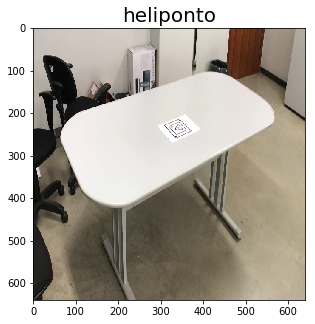

In [3]:
camera = cv2.imread('../Img_Teste_Gustavo/img_vid01_0.tif', cv2.IMREAD_COLOR)
camera_rgb = cv2.cvtColor(camera, cv2.COLOR_BGR2RGB)
camera_rgb1 = camera_rgb
plt.figure(1,figsize=(5,5))
plt.title('heliponto', size=20)
plt.imshow(camera_rgb)
plt.show()

In [4]:
camera_rgb = camera_rgb.reshape((-1,3))

In [5]:
# A imagem em tres dimensoes R-G-B
print(type(camera_rgb))
print(camera_rgb.shape)

camera_rgb = camera_rgb.astype(np.float64)
GPU_names = get_available_gpus()
print(GPU_names)

<class 'numpy.ndarray'>
(409600, 3)
['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7']


In [6]:
K = 2
points = np.random.choice(np.arange(0, camera_rgb.shape[0]), size=K, replace=False)
centroids = camera_rgb[points, :]
print(centroids.shape)
print(camera_rgb[0:K, :].shape)

(2, 3)
(2, 3)


In [7]:
results = distribuited_fuzzy_C_means(camera_rgb, K, GPU_names, centroids, 20)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv2.kmeans(camera_rgb.astype(np.float32), K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [8]:
print(results['end_center'])
print(center)

[[ 211.61700154  205.2649469   196.20313137]
 [  91.59025337   82.81553629   68.17835604]]
[[ 202.50834656  194.98013306  182.91323853]
 [  87.82028198   78.92079163   64.96960449]]


In [9]:
print(results['cluster_idx'].shape)

(409600,)


In [10]:
results = distribuited_k_means(camera_rgb, K, GPU_names, centroids, 20)

In [11]:
print(results['cluster_idx'])

[0 0 0 ..., 0 0 0]


In [12]:
print(results['end_center'])
print(center)

[[ 202.78030078  195.27714969  183.23701455]
 [  88.28355244   79.35577901   65.35167108]]
[[ 202.50834656  194.98013306  182.91323853]
 [  87.82028198   78.92079163   64.96960449]]


# Testando com as imagens do video - Heliponto

Centroides do frame 4780


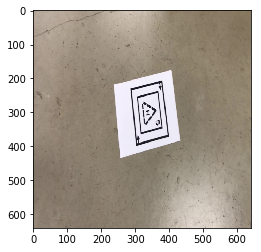

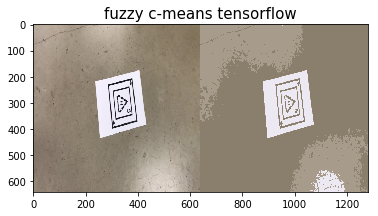

[[ 236.76304066  233.66188212  243.83753842]
 [ 167.93320569  155.54335372  140.10044233]
 [ 138.97424149  126.79113762  108.98473282]]
Tempo no frame 4780 
0.12150001525878906



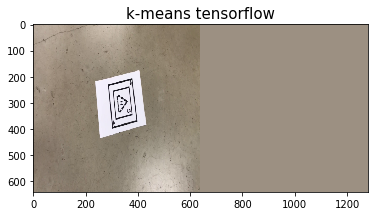

[[          nan           nan           nan]
 [          nan           nan           nan]
 [ 156.00783936  144.69745605  130.22777344]]
Tempo no frame 4780 
0.17942190170288086

Tempo k-means generico no frame 4780 
0.2795069217681885


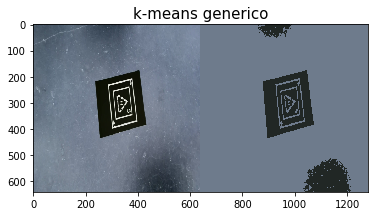

Centroides do frame 4781


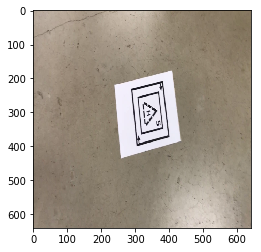

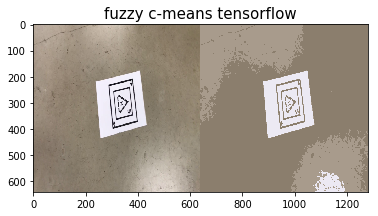

[[ 168.20657622  155.80734457  140.37204151]
 [ 236.7044301   233.76958799  243.86837717]
 [ 139.00340279  126.86628386  109.01557234]]
Tempo no frame 4781 
0.1338486671447754



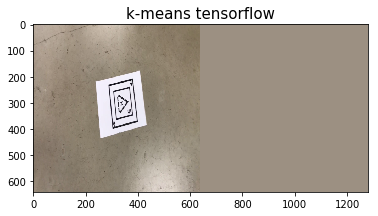

[[          nan           nan           nan]
 [          nan           nan           nan]
 [ 156.09001709  144.79934326  130.29242432]]
Tempo no frame 4781 
0.2180185317993164

Tempo k-means generico no frame 4781 
0.3232290744781494


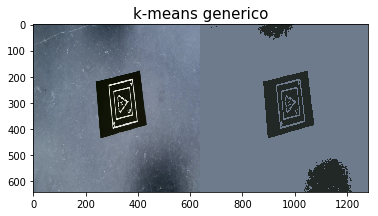

Centroides do frame 4782


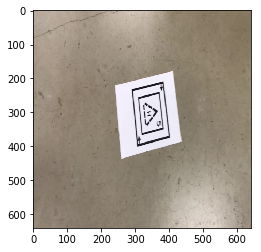

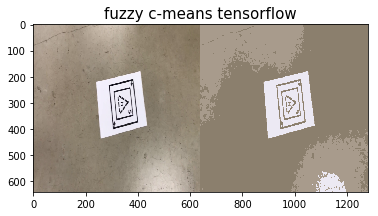

[[ 236.5181654   233.63138921  243.70926066]
 [ 139.29837594  127.13922909  109.29356861]
 [ 168.37189429  155.91923268  140.52700726]]
Tempo no frame 4782 
0.12118077278137207



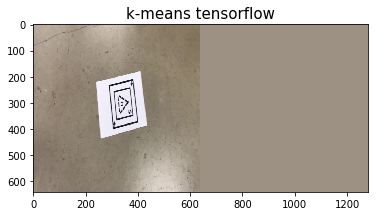

[[          nan           nan           nan]
 [ 156.41117676  145.0916748   130.59123291]
 [          nan           nan           nan]]
Tempo no frame 4782 
0.170823335647583

Tempo k-means generico no frame 4782 
0.3740882873535156


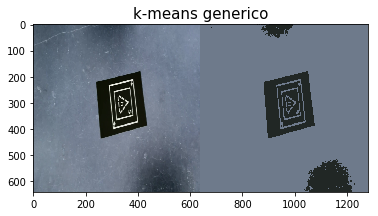

Centroides do frame 4783


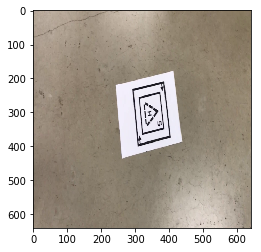

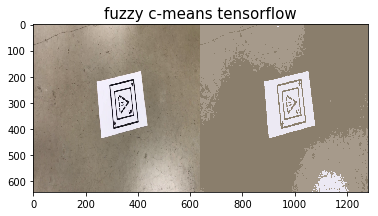

[[ 166.8447711   154.6216415   139.04635523]
 [ 236.70736131  233.71663417  243.7892652 ]
 [ 138.86557563  126.71037356  108.87874649]]
Tempo no frame 4783 
0.1387932300567627



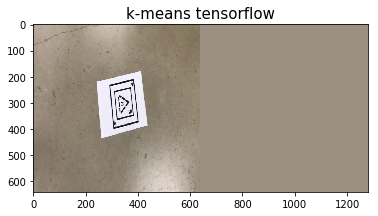

[[ 156.03091553  144.74243164  130.23034424]
 [          nan           nan           nan]
 [          nan           nan           nan]]
Tempo no frame 4783 
0.20828461647033691

Tempo k-means generico no frame 4783 
0.3571012020111084


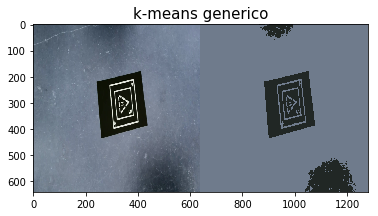

Centroides do frame 4784


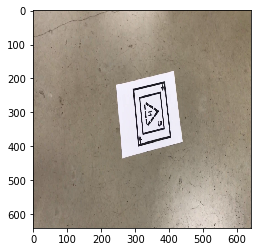

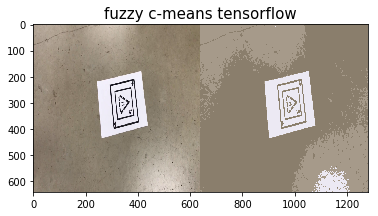

[[ 166.00521204  154.04975678  138.07241996]
 [ 236.79766532  233.84437901  243.62738293]
 [ 138.25456388  126.29726304  108.47568661]]
Tempo no frame 4784 
0.1173696517944336



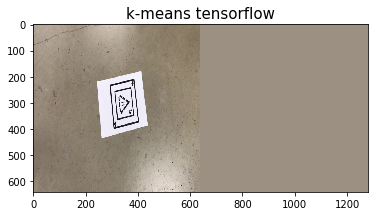

[[          nan           nan           nan]
 [          nan           nan           nan]
 [ 155.84310059  144.7243457   130.11971924]]
Tempo no frame 4784 
0.17948126792907715

Tempo k-means generico no frame 4784 
0.3416476249694824


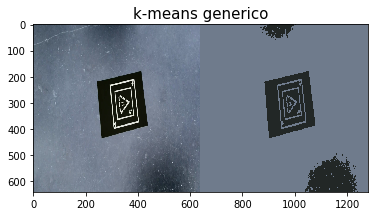

In [13]:
images = glob.glob('../Img_Teste_Gustavo/img_vid01_*.tif')

for fname in range(len(images))[-5:]:
    print('Centroides do frame %d' % (fname))
    img = mpimg.imread('../Img_Teste_Gustavo/img_vid01_%d.tif' % (fname))
    plt.imshow(img)
    plt.show()
    img1=img.copy()
    img = img.reshape((-1,3))
    img = img.astype(np.float64)
    GPU_names = get_available_gpus()
    K = 3
    points = np.random.choice(np.arange(0, img.shape[0]), size=K, replace=False)
    centroids = img[points, :]
    
    ### fuzzy c-means tensorflow
    results = distribuited_fuzzy_C_means(img, K, GPU_names, centroids, 20)

    center = np.uint8(results['end_center'])
    res = center[results['cluster_idx'].flatten()]
    res = res.reshape((img1.shape[0],img1.shape[1],3))
    res2 = img1.reshape((img1.shape[0],img1.shape[1],3))
    plt.figure(1)
    plt.title('fuzzy c-means tensorflow', size=15)
    plt.imshow(np.hstack([res2, res]))
    plt.show()
    
    print(results['end_center'])
    print('Tempo no frame %d ' % (fname))
    print(results['computation_time'])
    print('')
    
    ### k-means tensorflow
    results = distribuited_k_means(img, K, GPU_names, centroids, 20)

    center = np.uint8(results['end_center'])
    res = center[results['cluster_idx'].flatten()]
    res = res.reshape((img1.shape[0],img1.shape[1],3))
    res2 = img1.reshape((img1.shape[0],img1.shape[1],3))
    plt.figure(1)
    plt.title('k-means tensorflow', size=15)
    plt.imshow(np.hstack([res2, res]))
    plt.show()
    
    print(results['end_center'])
    print('Tempo no frame %d ' % (fname))
    print(results['computation_time'])
    print('')
    
    ### com k-means do opencv - comparacao
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    img2 = img1.reshape((img1.shape[0] * img1.shape[1], 3))
    img2 = img2.astype(np.float32)
    start_kmeans = time.time()
    ret,label,center=cv2.kmeans(img2,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    end = time.time()
    tempo=(end - start_kmeans)
    print('Tempo k-means generico no frame %d ' % (fname))
    print(tempo)
    center = np.uint8(center)
    res = center[label.flatten()]
    res = res.reshape((img1.shape[0],img1.shape[1],3))
    res2 = img2.reshape((img1.shape[0],img1.shape[1],3))
    plt.figure(1)
    plt.title('k-means generico', size=15)
    plt.imshow(np.hstack([res2, res]))
    plt.show()